In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615))
                                       ])


In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


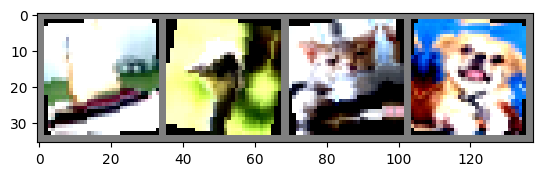

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [46]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24


        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding = 1, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding = 1, bias=False),
            nn.GroupNorm(num_groups=2, num_channels=16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding = 1, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding = 1, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding = 0, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding = 0, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)        
        x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [47]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
         GroupNorm-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
         GroupNorm-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
          Dropout-10           [-1, 16, 32, 32]               0
        MaxPool2d-11           [-1, 16, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]           4,608
        GroupNorm-13           [-1, 32, 16, 16]              64
             ReLU-14           [-1

In [48]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [49]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 21
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8168070316314697 Batch_id=390 Accuracy=24.49: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s]



Test set: Average loss: 1.7520, Accuracy: 3393/10000 (33.93%)

EPOCH: 1


Loss=1.5974829196929932 Batch_id=390 Accuracy=36.95: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]



Test set: Average loss: 1.5540, Accuracy: 4328/10000 (43.28%)

EPOCH: 2


Loss=1.7101666927337646 Batch_id=390 Accuracy=42.02: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]



Test set: Average loss: 1.4229, Accuracy: 4863/10000 (48.63%)

EPOCH: 3


Loss=1.5423022508621216 Batch_id=390 Accuracy=45.43: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]



Test set: Average loss: 1.3928, Accuracy: 4921/10000 (49.21%)

EPOCH: 4


Loss=1.1707112789154053 Batch_id=390 Accuracy=48.58: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]



Test set: Average loss: 1.3263, Accuracy: 5070/10000 (50.70%)

EPOCH: 5


Loss=1.356349229812622 Batch_id=390 Accuracy=50.74: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s] 



Test set: Average loss: 1.2637, Accuracy: 5491/10000 (54.91%)

EPOCH: 6


Loss=1.2588133811950684 Batch_id=390 Accuracy=52.59: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]



Test set: Average loss: 1.1722, Accuracy: 5788/10000 (57.88%)

EPOCH: 7


Loss=1.3893835544586182 Batch_id=390 Accuracy=54.14: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 1.2097, Accuracy: 5696/10000 (56.96%)

EPOCH: 8


Loss=0.9878670573234558 Batch_id=390 Accuracy=56.05: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]



Test set: Average loss: 1.1420, Accuracy: 5903/10000 (59.03%)

EPOCH: 9


Loss=1.3284728527069092 Batch_id=390 Accuracy=57.51: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]



Test set: Average loss: 1.1423, Accuracy: 5996/10000 (59.96%)

EPOCH: 10


Loss=1.1298195123672485 Batch_id=390 Accuracy=58.28: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]



Test set: Average loss: 1.0461, Accuracy: 6284/10000 (62.84%)

EPOCH: 11


Loss=1.1020153760910034 Batch_id=390 Accuracy=59.60: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 1.0480, Accuracy: 6276/10000 (62.76%)

EPOCH: 12


Loss=1.1031863689422607 Batch_id=390 Accuracy=60.31: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 1.0755, Accuracy: 6090/10000 (60.90%)

EPOCH: 13


Loss=1.0827367305755615 Batch_id=390 Accuracy=61.37: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s]



Test set: Average loss: 1.0568, Accuracy: 6214/10000 (62.14%)

EPOCH: 14


Loss=1.039304494857788 Batch_id=390 Accuracy=61.75: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s] 



Test set: Average loss: 1.0136, Accuracy: 6353/10000 (63.53%)

EPOCH: 15


Loss=0.9757360219955444 Batch_id=390 Accuracy=62.54: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s]



Test set: Average loss: 0.9771, Accuracy: 6558/10000 (65.58%)

EPOCH: 16


Loss=1.1596219539642334 Batch_id=390 Accuracy=63.49: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]



Test set: Average loss: 0.9438, Accuracy: 6629/10000 (66.29%)

EPOCH: 17


Loss=1.3658783435821533 Batch_id=390 Accuracy=63.53: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]



Test set: Average loss: 0.9633, Accuracy: 6598/10000 (65.98%)

EPOCH: 18


Loss=0.9038194417953491 Batch_id=390 Accuracy=63.89: 100%|██████████| 391/391 [01:02<00:00,  6.30it/s]



Test set: Average loss: 0.9272, Accuracy: 6742/10000 (67.42%)

EPOCH: 19


Loss=0.9089853167533875 Batch_id=390 Accuracy=64.18: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 0.9683, Accuracy: 6567/10000 (65.67%)

EPOCH: 20


Loss=1.0376213788986206 Batch_id=390 Accuracy=64.96: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]



Test set: Average loss: 0.9866, Accuracy: 6464/10000 (64.64%)



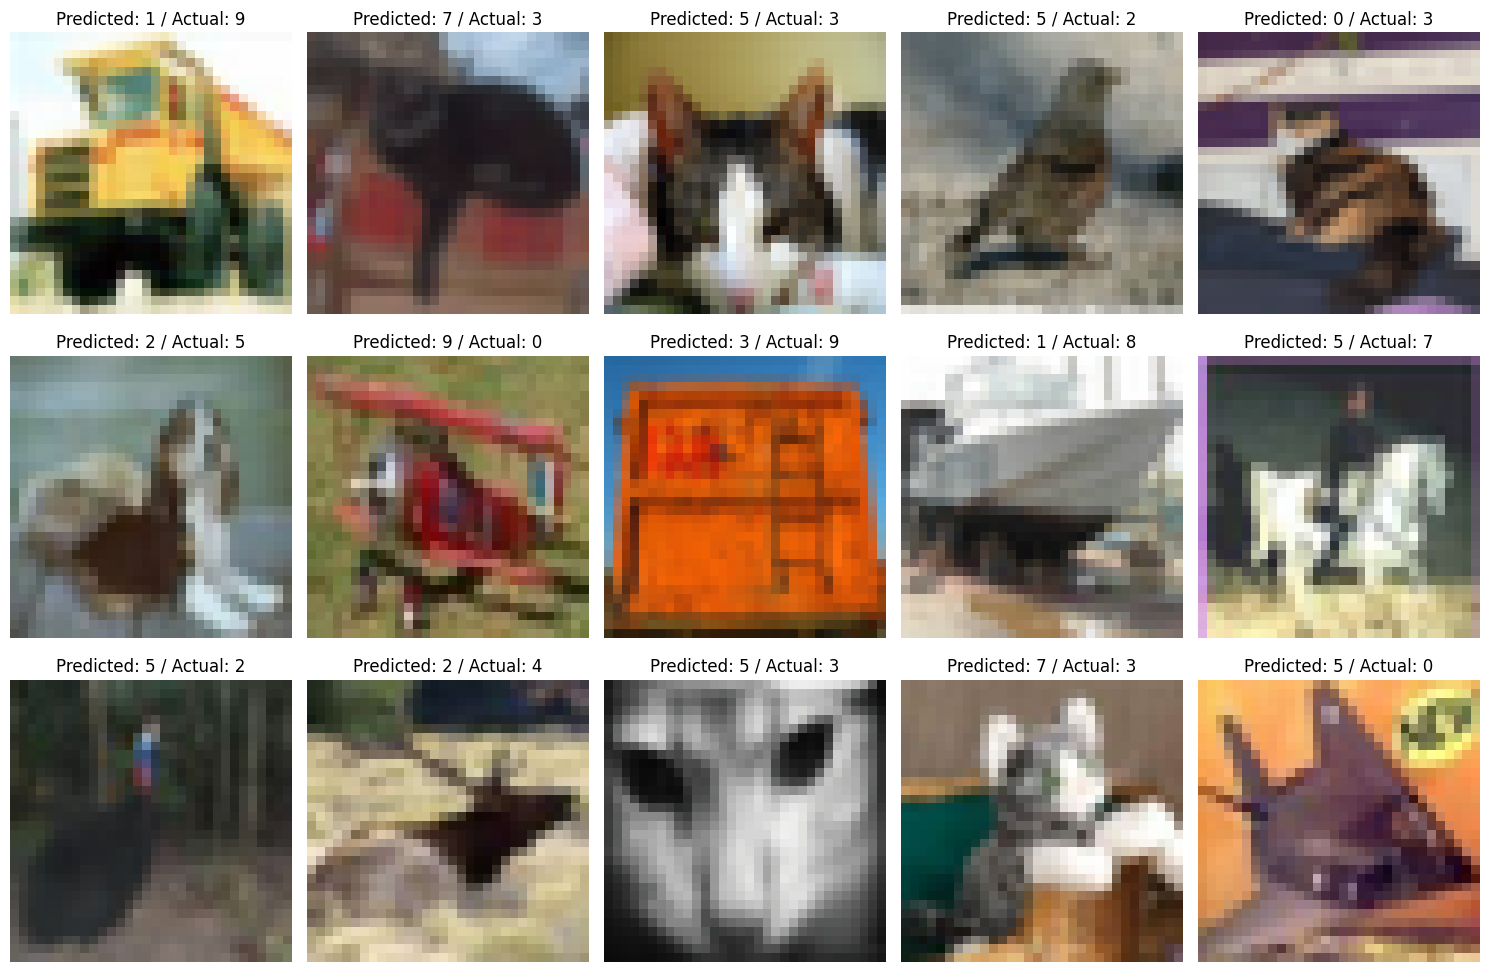

In [54]:
# Define function to get misclassified images
def get_misclassified_images(model, test_loader, device):
    misclassified_images = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            incorrect_pred = pred.squeeze() != target
            misclassified_images.extend([(img, pred, target) for img, pred, target in zip(data[incorrect_pred], pred[incorrect_pred], target[incorrect_pred])])
            if len(misclassified_images) >= 10:
                break
    return misclassified_images

# Get misclassified images
misclassified_images = get_misclassified_images(model, test_loader, device)

# Display misclassified images
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i, (img, pred, target) in enumerate(misclassified_images):
    if i < 15:  # Ensure we don't exceed the number of subplots
        row = i // 5
        col = i % 5

        img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy and transpose dimensions
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2434, 0.2615])
        img = std * img + mean  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip to [0, 1]
        axs[row, col].imshow(img)
        axs[row, col].set_title(f'Predicted: {pred.item()} / Actual: {target.item()}')
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

# Target

# Results

# Analysis